### Example Network Loading and Reconstruction Script

In [1]:
# import libraries

from os.path import join
import json
import numpy as np
import matplotlib.pyplot as plt
import torch

import utils.tof
import utils.utils
from nets.MaskToFNet import MaskToFNet
from dataloader import transforms
from dataloader.dataloader import LightFieldDataset

class Dummy(object):
    pass

In [2]:
# Instantiate dataloader just like in train.py, this may take a while

val_transform_list = [transforms.RGBtoNIR(), transforms.ToTensor()]
val_transform = transforms.Compose(val_transform_list)
val_data = LightFieldDataset(dataset_name="4DLFB", mode="val", transform=val_transform)

In [3]:
checkpoint_path = "nets/pretrained/bernoulli/" # path to network checkpoint
with open(join(checkpoint_path, "args.json")) as f: # create an args object
    data = json.load(f)
    args = Dummy()
    for k,v in data.items():
        setattr(args, k, v)        
args.f_list = [float(f) for f in args.f_list.split(",")]
mask = torch.load(join(checkpoint_path, "mask_latest.pt"), map_location="cpu").detach().cpu()
net = MaskToFNet(args, device="cpu")
net.load_state_dict(torch.load(join(checkpoint_path, "net_latest.pt"), map_location="cpu")["state_dict"])

<All keys matched successfully>

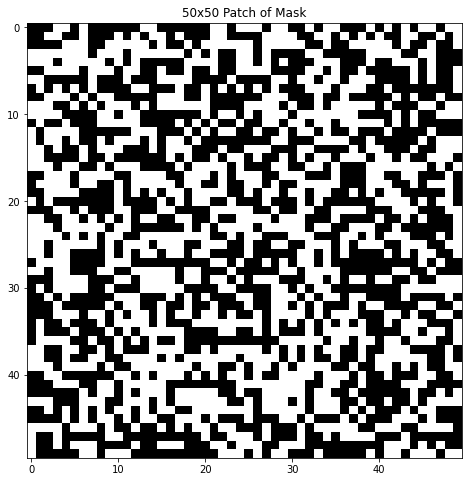

In [4]:
# Plot Mask Structure

net_mask = net.amplitude_mask.get_mask_internal() # load internal mask
plt.figure(figsize=(8,8))
plt.imshow(net_mask[0,0,:50,:50], cmap="gray")
plt.title("50x50 Patch of Mask")
plt.show()

In [5]:
i = 0 # sample index

sample = val_data[i]
lightfield = sample['lightfield'].unsqueeze(0) # fake batch dim
depth = sample['depth'].unsqueeze(0)
depth_gt = sample['depth_gt'].squeeze()
parameters = sample['parameters']

In [6]:
# Simulate amplitude images

view = lightfield[:,0] # 0th sub-aperture view
amplitude = utils.tof.sim_quad(depth_gt, args.f_list[0], args.T, args.g, view)

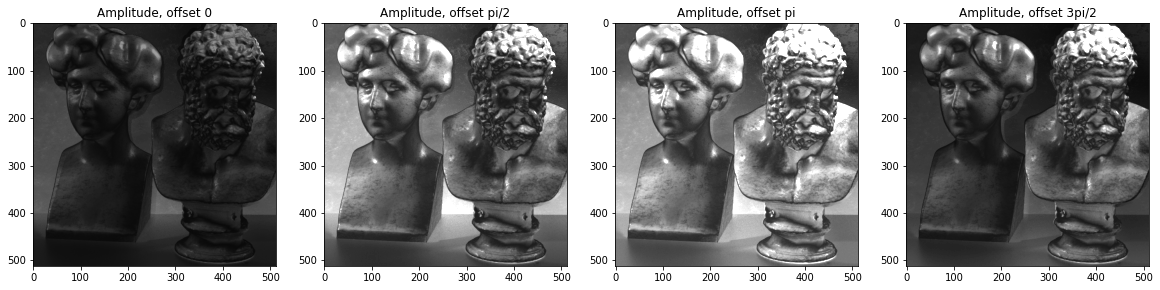

In [7]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(20,20)
axs[0].imshow(amplitude[0,0], cmap="gray", vmin=0, vmax=5000)
axs[0].set_title("Amplitude, offset 0")
axs[1].imshow(amplitude[0,1], cmap="gray", vmin=0, vmax=5000)
axs[1].set_title("Amplitude, offset pi/2")
axs[2].imshow(amplitude[0,2], cmap="gray", vmin=0, vmax=5000)
axs[2].set_title("Amplitude, offset pi")
axs[3].imshow(amplitude[0,3], cmap="gray", vmin=0, vmax=5000)
axs[3].set_title("Amplitude, offset 3pi/2")
plt.show()

In [8]:
# Run network

net.eval()
ret_optimized = net.forward(lightfield, depth, args, parameters, patch=False).squeeze().detach().cpu()

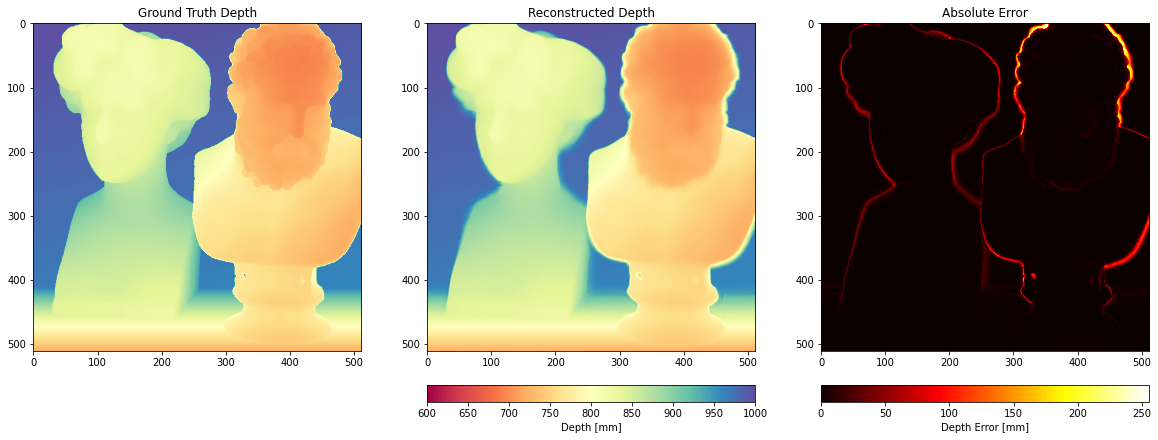

In [9]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(20,14)
axs[0].imshow(depth_gt, cmap="Spectral", vmin=600, vmax=1000)
axs[0].set_title("Ground Truth Depth")
d = axs[1].imshow(ret_optimized, cmap="Spectral", vmin=600, vmax=1000)
axs[1].set_title("Reconstructed Depth")
e = axs[2].imshow(torch.abs(depth_gt - ret_optimized), cmap="hot")
axs[2].set_title("Absolute Error")

left, bottom, width, height = axs[1].get_position().bounds
cax1 = fig.add_axes([left, bottom - 0.05, width, height * 0.05])
plt.colorbar(d, orientation='horizontal', cax=cax1, label="Depth [mm]")

left, bottom, width, height = axs[2].get_position().bounds
cax2 = fig.add_axes([left, bottom - 0.05, width, height * 0.05])
plt.colorbar(e, orientation='horizontal', cax=cax2, label="Depth Error [mm]")
plt.show()